<a href="https://colab.research.google.com/github/betsenara/Sentiment-Analysis-for-Mental-Health/blob/main/data_wrangling_eda.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer,PorterStemmer
import re
from sklearn.feature_extraction.text import TfidfVectorizer
import string
!pip install langdetect
from langdetect import detect

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
import os
os.getcwd()

'/content/drive/MyDrive/Colab Notebooks/Mental Health Sensitivity Analysis'

In [15]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Change to the desired directory in Google Drive
os.chdir('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis')

# Verify by listing files in the current directory
print(os.listdir())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['data_clean_english.csv', 'data_wrangling_eda.ipynb', 'data.csv']


In [81]:
#Read data
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/data.csv', encoding='ISO-8859-1')

In [85]:
data.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [86]:
data.shape

(53043, 3)

Check if each post belongs to a different person with different id:

In [87]:
data['Unnamed: 0'].nunique()

53043

We can drop the column 'Unnamed: 0' since it doesn't give extra information.

In [88]:
data.drop('Unnamed: 0', axis=1, inplace=True)

In [89]:
data.isna().sum()

,0
statement,362
status,0


The rows with null values can be dropped.

In [90]:
data.dropna(inplace=True)

### Duplicates

Check if the statements are unique.

In [91]:
data[['statement','status']].nunique()

,0
statement,51073
status,7


In [92]:
# the statements that are not unique:
data.loc[data['statement'].duplicated(keep=False),['statement','status']]

,statement,status
18,"""No regrets or grudges/angry at things that ha...",Anxiety
39,but my heart is still restless even though my ...,Anxiety
97,"""No regrets or grudges/angry at things that ha...",Anxiety
132,I want to exhale the restlessness in my chest ...,Anxiety
138,but my heart is still restless even though my ...,Anxiety
...,...,...
53038,Nobody takes me seriously Iâve (24M) dealt w...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


In [93]:
data.drop_duplicates(inplace = True)

### Language Detection

After preprocessing, we found that some posts in the data are not in English. We will remove the rows containing non-English statements.

In [94]:
# Function to detect the language
def detect_language(text):
    try:
        return detect(text)
    except:
        return None

# Apply the function to each row
data['language'] = data['statement'].apply(detect_language)

# Filter rows that are not in English
non_english_rows = data[data['language'] != 'en']
print(len(non_english_rows))

2757


In [95]:
# Drop the data in other languages
data.drop(non_english_rows.index, inplace=True)

In [96]:
print(f'There are {len(non_english_rows)} non-English rows. After dropping them, the shape of our dataframe is {data.shape}.')

There are 2757 non-English rows. After dropping them, the shape of our dataframe is (48336, 3).


In [97]:
data.drop('language', axis=1, inplace=True)

### Feature Extraction

We add a column that contains the number of words in the 'statement' column.

In [98]:
data['word_count'] = data['statement'].apply(lambda x: len(x.split()))

The statistics for that column are as follows:

In [99]:
data['word_count'].describe()

,word_count
count,48336.000000
mean,118.650633
std,166.597731
min,1.000000
25%,19.000000
50%,68.000000
75%,154.000000
max,6300.000000


In [100]:
data.loc[data['word_count']<3,'statement']

,statement
88,Anxious
332,Waiting anxiously
376,Restless tonight
424,anxious
738,No comeback~
...,...
44908,office time
44926,be offline
44959,horrible weather
44964,shattered


In [101]:
print(f'There are {data.loc[data["word_count"] < 3].shape[0]} rows with statements containing one or two words.')

There are 240 rows with statements containing one or two words.


### Value Counts: Number of Rows per Class

In [102]:
data['status'].value_counts()

,count
status,
Depression,14865
Normal,13665
Suicidal,10544
Anxiety,3578
Bipolar,2501
Stress,2290
Personality disorder,893


There is class imbalance. We will apply oversampling.

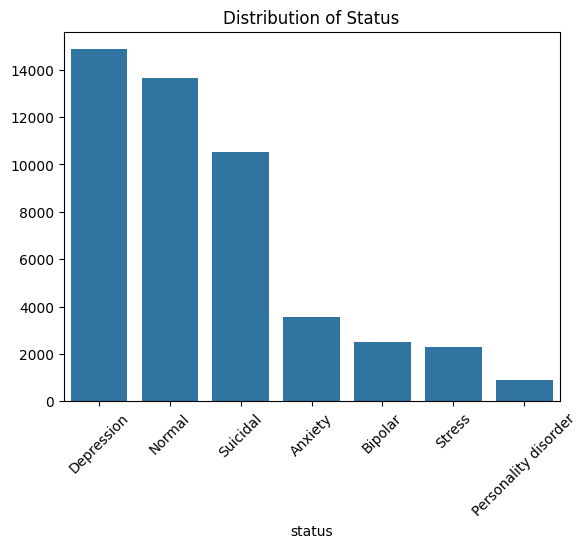

In [103]:
sns.barplot(x=data['status'].value_counts().index, y=data['status'].value_counts().values)
plt.title('Distribution of Status')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

### Word Count Statistics per Class

In [104]:
data.groupby('status')['word_count'].describe()

,count,mean,std,min,25%,50%,75%,max
status,,,,,,,,
Anxiety,3578.0,144.882337,152.238633,1.0,43.0,104.0,193.75,1592.0
Bipolar,2501.0,178.276689,180.933365,4.0,74.0,130.0,222.00,4804.0
Depression,14865.0,170.306492,188.754458,2.0,56.0,115.0,218.00,4239.0
Normal,13665.0,19.555434,23.984056,1.0,7.0,11.0,20.00,255.0
Personality disorder,893.0,178.237402,233.190293,5.0,65.0,133.0,234.00,5419.0
Stress,2290.0,111.955895,101.132138,3.0,65.0,86.0,122.00,1606.0
Suicidal,10544.0,147.615895,187.360941,2.0,43.0,93.0,187.00,6300.0


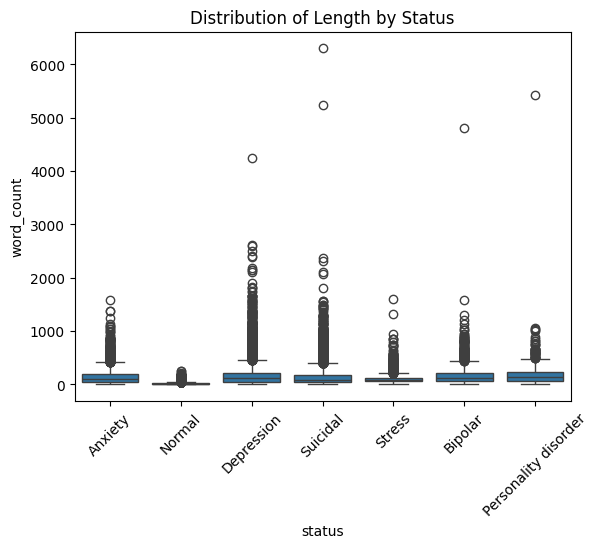

In [105]:
# Visualise the distribution of word count for all classes:
sns.boxplot(x='status', y='word_count', data=data)
plt.title('Distribution of Length by Status')
plt.xticks(rotation=45)  # Rotate x-axis labels by 45 degrees
plt.show()

In [106]:
avg_word_count = data.groupby('status')['word_count'].mean().reset_index()
fig = px.bar(avg_word_count, x='status', y='word_count',
             color='status', title="Average Word Counts Across Classes")
fig.show()


If we look at the graphs showing both the distribution and average word counts across different classes, we can see that people tagged as "normal" have much shorter posts compared to those tagged with a mental health condition. Although the "stress" group has longer posts than the normal group, it is the closest in length to the normal group compared to the other conditions. All other conditions show noticeably longer posts. There are some outliers and exteme values in word length:

In [107]:
# Print some of the long statements to get an idea of outliers:
for statement in data.loc[data['word_count']>2000,'statement']:
    print(f"S: {statement}\n")

S: So introduction I guess.. my name is Michael and I am 20 yo. I live in Slovakia though I would be surprised if anybody knew where that is located. And I am struggling with..I do not know maybe deppresion?The problems started like long time ago back when I was still a child. My mum hated the fuck out of my dad and for some reason my dad hated her too. My dad is like the typical stereotype guy who thinks that woman should be in kitchen taking care of her husband. He was and still is to be honest addicted to alcohol. I remember when I was a child and my mum had to go away for a couple of days that everytime my dad stepped through front door I prayed to god because I was always afraid that he arrives drunk again. I was so genuinely happy when he did not and I always hid in my closet when he did. In school I was not very popular. I am the kind of guy who thinks that if you have the means, if you have the option and ability to help somebody you should by all means do that. Of course peopl

## Cleaning the Corpus

The statements will be converted to lowercase and then cleaned by removing symbols, URLs, emojis, and alphanumeric characters.

In [108]:
def text_clean(text):
    def remove_emoji(text):
        emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251"  # Enclosed Characters
                               "]+", flags=re.UNICODE)
        return emoji_pattern.sub(r'',text)
    text = text.lower()
    text = re.sub(r'\S+@\S+','',text) # removing emails from text
    text = re.sub(r'https?://\S+|www\.\S+','',text) # removing urls from text
    text = re.sub(r'\d+','',text) # removing numbers from text
    text = re.sub(r'[^\w\s]','',text)  # removing all alphanumeric values from text
    text = text.strip() # removing leading and trailing whitespaces
    text = remove_emoji(text) #removing emojis from text
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)  # removing punctuation
    text = re.sub('\n', '', text) # removing newline characters
    text = re.sub(r'@\w+', '', text) # removing usernames in tweets

    return text

Tokenization, stemming, and lemmatization will be performed as follows.

In [109]:
stop_words=set(stopwords.words('english'))

def text_preprocess(text):
    # Initialize stemmer and lemmatizer
    stemmer = PorterStemmer()
    lemmatizer = WordNetLemmatizer()

    # Tokenize text
    tokens = word_tokenize(text)

    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]

    # Remove non-alphabetic characters and short tokens
    tokens = [word for word in tokens if word.isalpha() and len(word) > 1]

    # Stemming
    stemmed_tokens = [stemmer.stem(word) for word in tokens]

    # Lemmatization
    lemmatized_tokens = [lemmatizer.lemmatize(word) for word in tokens]

    # Return the cleaned, stemmed, and lemmatized tokens
    return {
        'original': tokens,
        'stemmed': stemmed_tokens,
        'lemmatized': lemmatized_tokens
    }

In [110]:
def clean_and_preprocess(df):
    df['statement_cleaned'] = df['statement'].apply(text_clean)
    df['stemmed'] = df['statement_cleaned'].apply(lambda x:text_preprocess(x)['stemmed'])
    df['lemmatized'] = df['statement_cleaned'].apply(lambda x:text_preprocess(x)['lemmatized'])
    return df

In [111]:
# clean and preprocess the data
data = clean_and_preprocess(data)

In [114]:
data.head()

,statement,status,word_count,statement_cleaned,stemmed,lemmatized
1,"trouble sleeping, confused mind, restless hear...",Anxiety,10,trouble sleeping confused mind restless heart ...,"[troubl, sleep, confus, mind, restless, heart,...","[trouble, sleeping, confused, mind, restless, ..."
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,14,all wrong back off dear forward doubt stay in ...,"[wrong, back, dear, forward, doubt, stay, rest...","[wrong, back, dear, forward, doubt, stay, rest..."
3,I've shifted my focus to something else but I'...,Anxiety,11,ive shifted my focus to something else but im ...,"[ive, shift, focu, someth, els, im, still, worri]","[ive, shifted, focus, something, else, im, sti..."
4,"I'm restless and restless, it's been a month n...",Anxiety,14,im restless and restless its been a month now ...,"[im, restless, restless, month, boy, mean]","[im, restless, restless, month, boy, mean]"
5,"every break, you must be nervous, like somethi...",Anxiety,14,every break you must be nervous like something...,"[everi, break, must, nervou, like, someth, wro...","[every, break, must, nervous, like, something,..."


In [115]:
# Saving the data

chunk_size = 5000  # Define chunk size

with open('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/data_clean.csv', 'w') as f:
    for i in range(0, len(data), chunk_size):
        data.iloc[i:i + chunk_size].to_csv(f, header=(i == 0), index=False,encoding='ISO-8859-1')

In [79]:

# load the data

# Define chunk size
chunk_size = 5000  # Adjust the chunk size as needed

# X_train
chunks = []

# Read in chunks
try:
    for chunk in pd.read_csv('/content/drive/My Drive/Colab Notebooks/Mental Health Sensitivity Analysis/data_clean.csv',
                             chunksize=chunk_size, encoding='ISO-8859-1',
                             engine='python'):
        chunks.append(chunk)

    # Concatenate all chunks into a single DataFrame
    data = pd.concat(chunks)

except Exception as e:
    print(f"An error occurred: {e}")


## Explanatory Data Analysis After Preprocessing

### Word Count After Lemmatization

In [116]:
data['lemmetized_word_counts'] = data['lemmatized'].apply(len)

In [60]:
X_train['lemmetized_word_counts'].describe()

,lemmetized_word_counts
count,38658.000000
mean,53.374722
std,73.840850
min,0.000000
25%,10.000000
50%,31.000000
75%,69.000000
max,2520.000000


The minimum word count has dropped to zero, indicating that some terms were removed during the cleaning process. We will investigate the number of these terms and eliminate them.

In [117]:
data.loc[data['lemmetized_word_counts']==0,['statement','lemmatized']]

,statement,lemmatized
743,What should I do :-(,[]
1868,where are you?,[]
2350,Where is this,[]
2651,what to do,[]
2733,What should we do,[]
2808,but how can you,[]
3518,then what are you doing now,[]
3950,can this be 2M,[]
3995,So this is it,[]
5012,But why?,[]


We observed that questions providing no information about sentiment have been eliminated during the lemmatization process. There are 88 such rows, which will be removed.

In [118]:
len(data.loc[data['lemmetized_word_counts']==0,'lemmatized'])

49

In [119]:
# Drop the rows with no words left after lemmetization
data.drop(data.loc[data['lemmetized_word_counts']==0].index, inplace=True)

### Most Common Words in the Corpus

In [122]:
from collections import Counter
top_words = Counter([word for row in data['lemmatized'] for word in row])

In [123]:
df_words = pd.DataFrame(top_words.most_common(40),columns=['words','count']).reset_index(drop=True)
df_words.style.hide(axis="index")
df_words.style.background_gradient(cmap='Blues')

,words,count
0,like,36927
1,feel,34277
2,want,27789
3,know,23654
4,life,22402
5,get,22327
6,time,20371
7,even,18066
8,would,16348
9,people,16188


In [124]:
px.treemap(df_words, path=['words'], values='count', title='Most Common Words in the Corpus')

In [69]:
pip install wordcloud matplotlib

In [125]:
from wordcloud import WordCloud

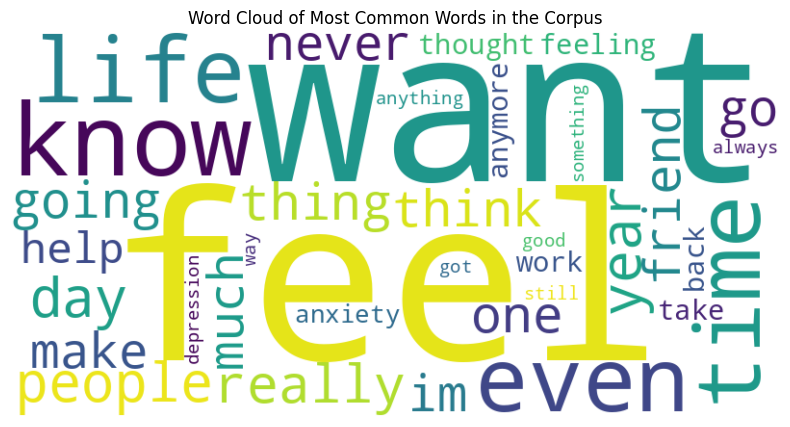

In [126]:
# Create a WordCloud object
words_all_corpus = ' '.join(df_words['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_all_corpus)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Corpus')
plt.show()

## Most Common Words in Posts Tagged with Normal




In [127]:
top_words_normal = Counter([word for row in data.loc[data['status']=='Normal','lemmatized'] for word in row])
df_words_normal = pd.DataFrame(top_words_normal.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_normal.style.hide(axis="index")
df_words_normal.style.background_gradient(cmap='Blues')

,words,count
0,im,1220
1,want,1167
2,like,1148
3,time,899
4,dont,871
5,get,863
6,really,842
7,one,778
8,know,762
9,go,751


In [128]:
px.bar(df_words_normal, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Normal')

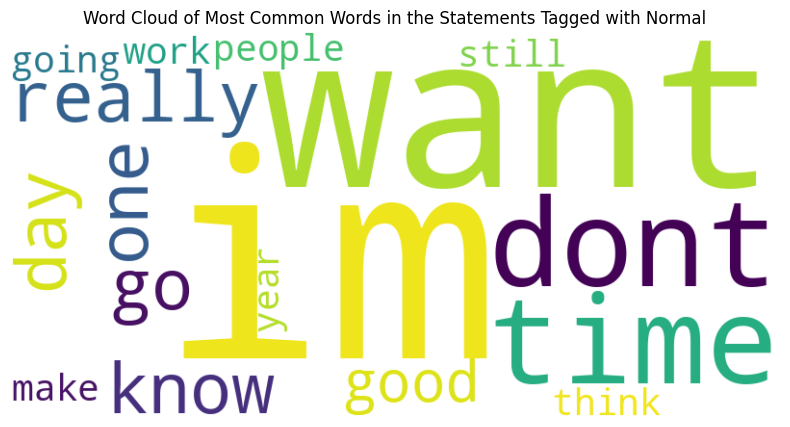

In [129]:
# Create a WordCloud object
words_normal = ' '.join(df_words_normal['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_normal)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Normal')
plt.show()

## Most Common Words in Posts Tagged with Depression

In [130]:
top_words_depression = Counter([word for row in data.loc[data['status']=='Depression','lemmatized'] for word in row])
df_words_depression = pd.DataFrame(top_words_depression.most_common(20),columns=['words','count']).reset_index(drop=True)
df_words_depression.style.hide(axis="index")
df_words_depression.style.background_gradient(cmap='Blues')

,words,count
0,like,17993
1,feel,17892
2,want,12470
3,life,11271
4,know,10970
5,get,10383
6,time,9312
7,even,8986
8,people,7794
9,thing,7641


In [131]:
px.bar(df_words_depression, x='count', y='words',
       color='words', orientation='h',
       title='Most Common Words in Posts Tagged with Depression')

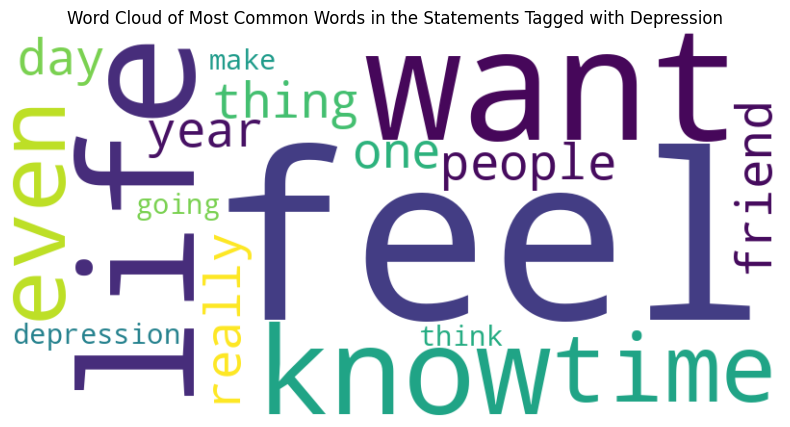

In [132]:
# Create a WordCloud object
words_depression = ' '.join(df_words_depression['words'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(words_depression)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Hide the axes
plt.title('Word Cloud of Most Common Words in the Statements Tagged with Depression')
plt.show()

When comparing the most common words used by individuals tagged as "normal" to those tagged with "depression," we find that words like "like," "want," "time," "get," "really," "one," "know," "would," "people," "they," "year," "think," "going," and "make" are frequently used across both groups. However, examining the words unique to each class could provide deeper insights.

# Unique Words Across Different Classes

In [133]:
all_words = set([word for row in data['lemmatized'] for word in row])
def unique_words(status,all_words,most_common_num):
  """
  status: desired tag of mental illness
  all_words: set of all words in the corpus
  most_common_num: number of most common words to return
  """
  # set of all words that do not belong to the tagged status
  rest_of_words = set([word for row in data.loc[data['status']!=status,'lemmatized'] for word in row])
  # set of all words that belong to the tagged status
  unique_words = all_words.difference(rest_of_words)
  # The words and their frequency that belongs to the tagged status uniquely
  Freq_unique_words = Counter([word for row in data.loc[data['status']==status,'lemmatized'] for word in row if word in unique_words])
  df_unique_words = pd.DataFrame(Freq_unique_words.most_common(most_common_num),columns=['words','count']).reset_index(drop=True)
  return df_unique_words


## Unique Words in Normal-Tagged Data

In [134]:
df_unique_words_normal = unique_words('Normal',all_words,30)
print("The top 10 unique words in Normal-Tagged posts are:")
df_unique_words_normal.style.background_gradient(cmap='Blues')

The top 10 unique words in Normal-Tagged posts are:


,words,count
0,dreamies,51
1,twitpic,34
2,rtlike,26
3,ãâ,25
4,nct,24
5,tinyurl,24
6,ãââãâ,22
7,awww,20
8,lebaran,19
9,nctzen,18


When we check these unique words we see that there are words that are not meaningful. If we further explore them in raw data:

In [135]:
# print rwa data to see the context of the words.
for statement in data.loc[data['lemmatized'].apply(lambda x:'dreamies' in x),'statement']:
    print(f"S: {statement}\n")

S: Dreamies that CB I'm excited about

S: Come on, what do you say to dreamies

S: Dreamies nunna is so proud of you guys, it's not in vain, I waited 5 years to get my 1st full album and then it's 7 dreams. You all deserve this. Thanks for our dreamzen fellas

S: what time is mv dreamies released?

S: I'm really touched that dreamies got to this point thank you all who have supported dreamies, thank you also for the 7 dreams that are still surviving and struggling with sijeuni, ah, I'm touched. Let's make this kambek a success

S: Dreamies, your dreamzens are really cool

S: what's happier than waking up and seeing dreamies million seller

S: I'm really proud of you and dreamies it gives me goosebumps Ã¢Ë

S: really cool dreamies 'Å¡

S: I hope that with 1.71 million sellers of Dreamies, SM will open their eyes to see the potential of Dreamies and not waste it anymore

S: I'm so proud, oh my God, thank you dreamies for fighting until now 'Å¡

S: I'm so proud of Dreamies Ã¢ Ã¢ËÂ¹Ã¯Â¸


In [136]:
for statement in data.loc[data['lemmatized'].apply(lambda x:'twitpic' in x),'statement']:
    print(f"S: {statement}\n")

S: switchfoot http twitpic com y zl awww that s a bummer you shoulda got david carr of third day to do it d

S: why won t you show my location http twitpic com y e

S: http twitpic com y wr according to my bro our new puppy had a poo fight and wa covered in poop picture stolen from him

S: http twitpic com y yi i love you buck

S: http twitpic com y e i wan na wear my doc marten out haven t worn them since december

S: http twitpic com y e cant see the flower falling i dont have a camera just my cellphone

S: http twitpic com y cf filled with curry the true indian in me is coming out

S: danielledeleasa http twitpic com y pe i hate b allergic i want a puppy soo bad that i ve already thought some cool name

S: white trash v u we were outnumbered http twitpic com y jp

S: why can t i sleep like her http twitpic com y ty

S: sodding m http twitpic com y y0

S: i ve finally given in now at malaysian restaurant waiting for nasi lemak and teh tarik mereka tak faham bm http twitpic com y bh



"Upon examining the unique words, we see that some, like 'dreamies' and 'twitpic,' are not meaningful. The term 'twitpic' should have been removed during the cleaning process, but it was not identified because it was not in URL format. We might clean these words from the corpus but for now we will leave them."

In [ ]:
# Words that might be cleaned:
word_to_clean = []
for word in df_unique_words_normal['words']:
  if word not in ['dreamies','rtlike','nct','indonesia','hamper','itunes']:
    word_to_clean.append(word)


In [ ]:
"""
check_word = df_unique_words_normal.loc[16,'words']
print('word: '+ check_word )
for statement in data.loc[data['lemmatized'].apply(lambda x:check_word  in x),'statement']:
    print(f"S: {statement}\n")
    """

'\ncheck_word = df_unique_words_normal.loc[16,\'words\']\nprint(\'word: \'+ check_word )\nfor statement in data.loc[data[\'lemmatized\'].apply(lambda x:check_word  in x),\'statement\']:\n    print(f"S: {statement}\n")\n    '

## Unique Words in Depression-Tagged Data

In [137]:
df_unique_words_depression = unique_words('Depression',all_words,20)
print("The top 20 unique words in Depression-Tagged posts are:")
df_unique_words_depression.style.background_gradient(cmap='Oranges')

The top 20 unique words in Depression-Tagged posts are:


,words,count
0,mizzzidc,52
1,theekween,45
2,thelmasherbs,44
3,mentalhealth,28
4,pogba,24
5,mourinho,16
6,fuckfuckfuck,15
7,wort,12
8,tto,12
9,healthgrades,11


In [138]:
df_unique_words_anxiety = unique_words('Anxiety',all_words,10)
print("The top 10 unique words in Anxiety-Tagged posts are:")
df_unique_words_anxiety.style.background_gradient(cmap='Greens')

The top 10 unique words in Anxiety-Tagged posts are:


,words,count
0,hantavirus,24
1,asbestos,12
2,mammogram,11
3,droppings,10
4,esophageal,10
5,platelet,9
6,thermometer,9
7,parkinsonâs,9
8,avocado,8
9,prolapse,7


In [139]:
df_unique_words_suicidal = unique_words('Suicidal',all_words,10)
print("The top 10 unique words in Suicidal-Tagged posts are:")
df_unique_words_suicidal.style.background_gradient(cmap='Greens')

The top 10 unique words in Suicidal-Tagged posts are:


,words,count
0,wallsim,128
1,thath,14
2,gangsta,12
3,guild,10
4,ich,9
5,antagonise,8
6,cuzz,8
7,aãââ,8
8,iãââve,8
9,taunting,7


Upon examining the unique words for each class, we find that many are not
meaningful and include usernames or noise. This issue may be due to the presence of multiple classes. Words appearing in more than one class are often removed.

# Cosine Similarity Using Word2Vec

Here when preprocessing we have to keep the sentences separately in each statement since the context is important for embedding. Preprocessing of the sentences is done below.

In [140]:
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize

# Preprocess text: tokenize into sentences, then words
def preprocess_sentences(text):
    # Tokenize into sentences
    sentences = sent_tokenize(text)
    # Preprocess each sentence
    cleaned_sentences = [text_clean(sentence) for sentence in sentences]
    tokenized_sentences = [text_preprocess(sentence)['lemmatized'] for sentence in cleaned_sentences]
    return tokenized_sentences

# Apply preprocessing to each statement in the DataFrame
processed_statements = [preprocess_sentences(statement) for statement in data['statement']]

# Flatten the list of lists to create a union of all sentences
sentences = [sentence for statement in processed_statements for sentence in statement]

# 2. Train Word2Vec model
model = Word2Vec(sentences=sentences, vector_size=100, window=5, min_count=1, sg=0)


In [175]:
def create_corr_heatmap(model, desired_words,show_corr_values=False):
  word_vectors = {}
  for word in desired_words:
    if word in model.wv:
            word_vectors[word] = model.wv[word]
    else:
      print(f"'{word}' is not in the model's vocabulary.")
  # Create a matrix of word vectors
  vector_matrix = np.array([word_vectors[word] for word in desired_words if word in word_vectors])

  # Compute cosine similarity matrix
  similarity_matrix = cosine_similarity(vector_matrix)

  # Create a DataFrame for the similarity matrix
  similarity_df = pd.DataFrame(similarity_matrix, index=[word for word in desired_words if word in word_vectors],
                             columns=[word for word in desired_words if word in word_vectors])

  # Plot heatmap
  plt.figure(figsize=(10, 8))
  sns.heatmap(similarity_df, annot=show_corr_values, cmap='coolwarm', vmin=-1, vmax=1)
  plt.title('Cosine Similarity Between Most Common Words')
  plt.show()



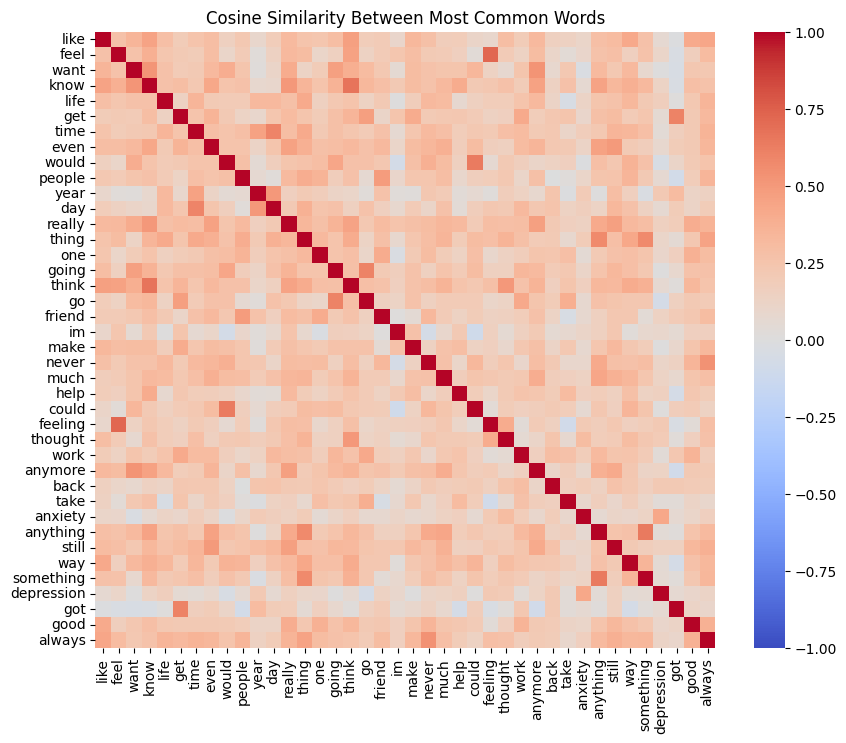

In [176]:
common_words = df_words['words']
create_corr_heatmap(model, common_words)

### Some Selected Words

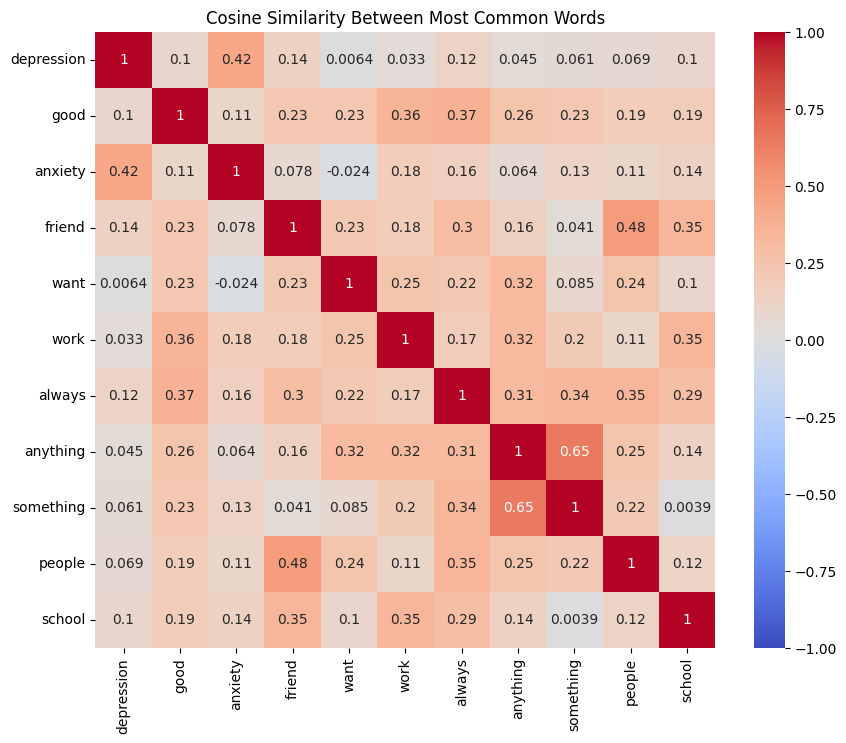

In [184]:
selected_words = ['depression', 'good', 'anxiety', 'friend', 'want', 'work','always','anything','something','people','school']
create_corr_heatmap(model, selected_words,show_corr_values=True)

If we check the values, we onserve that 'anything' and 'something' has a correlation of 0.65 which is moderate positive correlation. The words 'anxiety' and 'depression' are also positively correlated. The words 'good' and 'depression' has very low correlation. 'want' and 'anxiety' are negatively correlated.

In [188]:
# Save the trained Word2Vec model
model.save("word2vec_model.model")

In [191]:
# Load the word vectors
model = Word2Vec.load("word2vec_model.model")